In [1]:
from data_process import *
from PLE2 import PLE2
import logging,sys

In [2]:
BATCH_SIZE = 4096
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
out_f = './train.txt'
logging.basicConfig(filename= out_f , level=logging.INFO, filemode='a',
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

In [3]:
# 加载数据
dataset, watch_label, share_label = load_train_datas()

-- Mem. usage decreased to 1928.41 Mb (65.5% reduction),time spend:0.45 min


In [4]:
# 将分类label 变为回归label
watch_label_ratio = watch_label / 10

In [5]:
# 划分数据集，得到训练集和验证集
train_data, train_label, validation_data, validation_label = split_dataset(dataset, watch_label_ratio, share_label)

In [6]:
# 归一化数据
train_data_QT = QuantileTransformer(output_distribution='uniform').fit_transform(train_data)
validation_data_QT = QuantileTransformer(output_distribution='uniform').fit_transform(validation_data)

# 拼接两个label
train_label_tmp = np.column_stack([train_label[0],train_label[1]])
validation_label_tmp = np.column_stack([validation_label[0], validation_label[1]])

In [70]:
# 训练
def train_model(model, batch_size, lr=3e-4, n_epochs=50, patience=15):
    # 封装数据为dataloader
    train_loader = DataLoader(dataset=getTensorDataset(train_data_QT, train_label_tmp), batch_size=batch_size)
    val_loader = DataLoader(dataset=getTensorDataset(validation_data_QT, validation_label_tmp), batch_size=batch_size)    

    # Defines loss function and optimizer
    loss_wh_fn = nn.MSELoss(reduction='mean')
    loss_sh_fn = nn.BCELoss(reduction='mean')
    early_stopping = EarlyStopping(patience, verbose=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    val_losses = []
#     watch_auc = []
#     share_auc = []
#     sum_auc = []

    # model init
    def init_weights(m):
        if type(m) in [nn.Linear]:
            nn.init.normal_(m.weight, std =0.01)
    model.apply(init_weights)
    
    devices = [0, 1]
    model = nn.DataParallel(model, device_ids=devices)

    # Training loop
    for epoch in range(n_epochs):
        model.train()

        # Uses loader to fetch one mini-batch for training
        epoch_loss = []
        c = 0
        print("\nEpoch: {}/{}".format(epoch, n_epochs)) 
        for x_batch, y_batch in train_loader:

            # NOW, sends the mini-batch data to the device
            # so it matches location of the MODEL
            x_batch = x_batch.to(devices[0])
            y_batch = y_batch.to(devices[0])
            
#             print(y_batch)
#             print(y_batch.shape)
            
            # One stpe of training
            yhat = model(x_batch.float())
#             print(len(yhat))
#             print(yhat[0].shape)
#             break
            

            # compute Loss
            wh_loss = loss_wh_fn(yhat[0].squeeze(1).float(), y_batch[:, 0].float())
            sh_loss = loss_sh_fn(yhat[1].squeeze(1).float(), y_batch[:, 1].float())        
            loss = wh_loss + sh_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            c += 1
            if c % 10 == 0:     
                mesg = f'[Batch: {c}]' + \
                         f'train_loss: {np.mean(loss.item()):.5f} '
                logging.info(mesg)
        losses.append(np.mean(epoch_loss))

        # After finishing training steps for all mini-batches,
        # it is time for evaluation!

        # We tell PyTorch to NOT use autograd...
        with torch.no_grad():
            # Uses loader to fetch one mini-batch for validation
            epoch_loss = []
            epoch_watch_auc = []
            epoch_share_auc = []
            epoch_sum_auc = []
            for x_val, y_val in val_loader:
                # Again, sends data to same device as model
                x_val = x_val.to(devices[0])
                y_val = y_val.to(devices[0])

                model.eval()
                # Makes predictions
                yhat = model(x_val.float()) # len=11, 一组batch的预测值

                # Computes validation loss
                wh_loss = loss_wh_fn(yhat[0].squeeze(1).float(), y_val[:, 0].float())
                sh_loss = loss_sh_fn(yhat[1].squeeze(1).float(), y_val[:, 1].float())        
                loss = wh_loss + sh_loss

                epoch_loss.append(loss.item())

        val_losses.append(np.mean(epoch_loss))

        epoch_len = len(str(n_epochs))
        mesg = f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + \
                         f'train_loss: {losses[-1]:.5f} ' + \
                         f'valid_loss: {val_losses[-1]:.5f}'
        logging.info(mesg)

        # ************* Early Stopping ****************
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # print(model.state_dict())
    print("loss: ", np.mean(losses))
    print("val_loss: ", np.mean(val_losses))
    
    return losses, val_losses

In [71]:
# 定义模型
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = PLE2(num_feature=128, num_experts=16, num_tasks=2, units=256, towers_hidden=32, selectors=2)
model = model.to(device)

In [72]:
# Sets hyper-parameters
lr = 1e-4 * 1.5
n_epochs = 50
patience = 10
BATCH_SIZE = 4096 * 2
losses, val_losses = train_model(model, batch_size=BATCH_SIZE, lr=lr, patience=patience)


Epoch: 0/50
[Batch: 10]train_loss: 0.91773 
[Batch: 20]train_loss: 0.91363 
[Batch: 30]train_loss: 0.90477 
[Batch: 40]train_loss: 0.88065 
[Batch: 50]train_loss: 0.82393 
[Batch: 60]train_loss: 0.70198 
[Batch: 70]train_loss: 0.47363 
[Batch: 80]train_loss: 0.26671 
[Batch: 90]train_loss: 0.25635 
[Batch: 100]train_loss: 0.16114 
[Batch: 110]train_loss: 0.08882 
[Batch: 120]train_loss: 0.08961 
[Batch: 130]train_loss: 0.08208 
[Batch: 140]train_loss: 0.09473 
[Batch: 150]train_loss: 0.09187 
[Batch: 160]train_loss: 0.08589 
[Batch: 170]train_loss: 0.08370 
[Batch: 180]train_loss: 0.08452 
[Batch: 190]train_loss: 0.08529 
[Batch: 200]train_loss: 0.08417 
[Batch: 210]train_loss: 0.08784 
[Batch: 220]train_loss: 0.08804 
[Batch: 230]train_loss: 0.08738 
[Batch: 240]train_loss: 0.08243 
[Batch: 250]train_loss: 0.08496 
[Batch: 260]train_loss: 0.07753 
[Batch: 270]train_loss: 0.08648 
[Batch: 280]train_loss: 0.08017 
[Batch: 290]train_loss: 0.09270 
[Batch: 300]train_loss: 0.08926 
[Batch

KeyboardInterrupt: 

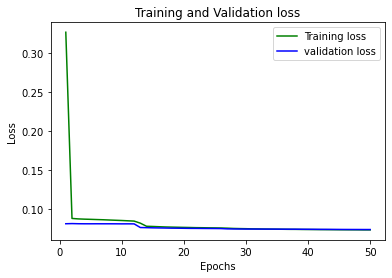

In [52]:
epochs = range(1, len(losses)+1)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
test_data = load_test_datas()

-- Mem. usage decreased to 820.89 Mb (65.7% reduction),time spend:0.20 min


In [54]:
# 将测试数据组织为 DaTaloader
test_loader = DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(test_data.astype(float).to_numpy())), batch_size=4096*2)

In [55]:
def predict():
    # 预测
    watch_pred = []
    share_pred = []
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for testing
        for x_test in test_loader:
            # Again, sends data to same device as model
            x_test = x_test[0]
            x_test = x_test.to(device)

            model.eval()
            # Makes predictions
            yhat = model(x_test.float())
#             print(yhat)
# #             print(yhat[0].shape)
#             break
#             print(yhat)
            yhat_watch = yhat[0]
#             print(yhat_watch.shape)
            yhat_share = yhat[1]
#             print(yhat_share.shape)
            
            
            # save
            watch_pred.append(yhat_watch)
            share_pred.append(yhat_share)
    return watch_pred, share_pred

In [56]:
wh_pred, sh_pred = predict()

In [57]:
wh_preds = torch.cat(wh_pred, axis = 0)

In [58]:
wh_preds.shape

torch.Size([2822180, 1])

In [59]:
res = np.rint(wh_preds.squeeze(1).cpu().numpy() * 10)

In [60]:
Counter(res)

Counter({0.0: 2710859, 3.0: 86139, 2.0: 9027, 1.0: 16155})

In [56]:
sh_preds = torch.cat(sh_pred, axis = 0)

In [57]:
sh_preds.shape

torch.Size([2822180, 1])

In [58]:
sh_preds = sh_preds.cpu().squeeze(1).numpy()

In [60]:
Counter(np.rint(sh_preds))

Counter({0.0: 2822180})